# MODEL BIAS


**This notebook showcases data cleaning and predictions performed on 1,000 molecules compounds represented by SMILES to conduct a Model Bias Evaluation in the Ersilia Model Hub.**

**The dataset used is "reference_library.csv" shared by the mentor for the contribution phase of outreachy Internship 2024.**

In [1]:
# Importing the necessary packages
!pip install rdkit
!pip install standardiser

import pandas as pd
from rdkit import RDLogger
from standardiser import standardise
import logging
# from os import path, remove

# Disable warning messages
logging.getLogger("standardiser.standardise").setLevel(logging.ERROR)
RDLogger.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for standardiser: filename=standardiser-0.1.9-py3-none-any.whl size=720101 sha256=72cf1cb043f3883916a3d5396988e6dada75c6b9accef9a0320eb174a1839e19
  Stored in directory: /root/.cache/pip/wheels/eb/62/4b/6044430bf5a732d53bd0d1aa165c928954d9f87cd92529f00f
Successfully built standardiser


In [2]:
# @title 🔗 Connect Colab to your Google Drive

## Mount google drive
from google.colab import drive

drive.mount("/content/drive")

## Click on the folder/directory icon to the left
##      and make sure your drive is mounted

Mounted at /content/drive


<div class="markdown-google-sans">

### 📩 Specify your file paths and the input .csv file
</div>

<div>

*  Make sure you have a .csv file containing a list of molecules represented as SMILES string
* Specify the exact column name of your smiles column in the .csv file
*  Specify the path to your file in Google Drive
*  Specify the path where you want to store the results in Google Drive

</div>

In [3]:
# specify your input folder

input_folder = "/content/drive/MyDrive/Ersilia"  # @param {type:"string"}

In [4]:
# specify your output folder

output_folder = "/content/drive/MyDrive/Ersilia"  # @param {type:"string"}

In [5]:
# specify the name of your input csv file

input_filename = "reference_library"  # @param {type:"string"}

In [6]:
# specify the SMILES column name
smiles_column = "smiles"  # @param {type:"string"}

# Data Cleaning and Preprocessing


I am loading a list of molecules I obtained from ChEMBL and processing them to make sure I have:
- Standard SMILES representation of the compound
- InChIKey associated to the compound

In [7]:
#reading my csv into a pandas data frame
path = "%s/%s.csv" % (input_folder, input_filename)
data = pd.read_csv(path)
data.head(5)

,smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...


In [35]:
#cloning my repo
!git clone 'https://github.com/Hamidatmohd/Ersilia-Model-Evaluation.git'

fatal: destination path 'Ersilia-Model-Evaluation' already exists and is not an empty directory.


In [9]:
# # Converting the molecules to standard SMILES by using the function standardise_smiles from /src

import sys
sys.path.append('/content/Ersilia-Model-Evaluation/src')

from smiles_processing import standardise_smiles

smiles_list = data['smiles'].tolist()
data['standardized_smiles'] = standardise_smiles(smiles_list)

In [10]:
#checking for null values
data.isna().sum()

smiles                 0
standardized_smiles    3
dtype: int64

In [11]:
#dropping the null values
data.dropna(subset=['standardized_smiles'], inplace=True)

In [12]:
#checking the top 5 rows
data.head()

,smiles,standardized_smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1,CCCCNC(=S)N/N=C/c1sccc1C
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1


In [37]:
#extracting inchi key from the smiles
from rdkit import Chem

def smiles_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        inchi = Chem.MolToInchi(mol)
        inchikey = Chem.InchiToInchiKey(inchi)
        return inchikey
    else:
        return None

data['inchikey'] = data['standardized_smiles'].apply(smiles_to_inchikey)

# Print the InChIKeys
print(data[['standardized_smiles', 'inchikey']])



                                   standardized_smiles  \
0                             CCCCNC(=S)N/N=C/c1sccc1C   
1                Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1   
2                   O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl   
3         O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1   
4    CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1   
..                                                 ...   
995  CCCn1c(-c2cnc(Nc3ccc(C)nc3)c(Cl)c2)nc2cccc(Cl)c21   
996           CN(Cc1cccc2ccccc12)Cn1nc(-c2ccncc2)oc1=O   
997  O=C(N[C@@H](CSCc1ccccc1)C(=O)Nc1ccc(C2S/C(=N\c...   
998  CN1CC[C@]23CCCC[C@H]2[C@H]1Cc1ccc(Oc2ccccc2F)cc13   
999  O=C(CN1C(=O)/C(=C/c2ccco2)SC1=S)Nc1ccc(C(=O)O)...   

                        inchikey  
0    SUTWUYBMBWPLMW-MDWZMJQESA-N  
1    RIYHJWOTNJXDLV-UHFFFAOYSA-N  
2    OGNBARHGQVMGGX-UHFFFAOYSA-N  
3    WQEXDIRUOYNDCM-UHFFFAOYSA-N  
4    YEGVLLQDOGYWDQ-OAHLLOKOSA-N  
..                           ...  
995  RGKVPYQYBUAAEH-UHFFFAOYSA-N  
996  VTRFEMUYHTXFEQ-UHF

In [14]:
data.head()

,smiles,standardized_smiles,inchikey
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1,CCCCNC(=S)N/N=C/c1sccc1C,SUTWUYBMBWPLMW-MDWZMJQESA-N
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,RIYHJWOTNJXDLV-UHFFFAOYSA-N
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,OGNBARHGQVMGGX-UHFFFAOYSA-N
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,WQEXDIRUOYNDCM-UHFFFAOYSA-N
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,YEGVLLQDOGYWDQ-OAHLLOKOSA-N


In [15]:
#extracting the relevant columns
df = pd.DataFrame(data, columns=['standardized_smiles', 'inchikey'])

In [16]:
df

,standardized_smiles,inchikey
0,CCCCNC(=S)N/N=C/c1sccc1C,SUTWUYBMBWPLMW-MDWZMJQESA-N
1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,RIYHJWOTNJXDLV-UHFFFAOYSA-N
2,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,OGNBARHGQVMGGX-UHFFFAOYSA-N
3,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,WQEXDIRUOYNDCM-UHFFFAOYSA-N
4,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,YEGVLLQDOGYWDQ-OAHLLOKOSA-N
...,...,...
995,CCCn1c(-c2cnc(Nc3ccc(C)nc3)c(Cl)c2)nc2cccc(Cl)c21,RGKVPYQYBUAAEH-UHFFFAOYSA-N
996,CN(Cc1cccc2ccccc12)Cn1nc(-c2ccncc2)oc1=O,VTRFEMUYHTXFEQ-UHFFFAOYSA-N
997,O=C(N[C@@H](CSCc1ccccc1)C(=O)Nc1ccc(C2S/C(=N\c...,QDFOYTHIYBSDPW-RGAOVNQFSA-N
998,CN1CC[C@]23CCCC[C@H]2[C@H]1Cc1ccc(Oc2ccccc2F)cc13,YZQZXLROYFNFQE-QTGUNEKASA-N


# Model Bias Evaluation

Now, I will run dataset of 1000 molecules curated above on the Ersilia eos6oli to predict solubility and  use the predictions to see how are they distributed in their space.


In [17]:
#installing miniconda and Ersilia
%%capture
%env MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.12.0-Linux-x86_64.sh
%env MINICONDA_PREFIX=/usr/local
%env PYTHONPATH= "$PYTHONPATH:/usr/local/lib/python3.7/site-packages"
%env PIP_ROOT_USER_ACTION=ignore

In [18]:
!wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
!chmod +x $MINICONDA_INSTALLER_SCRIPT
!./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

--2024-03-25 07:30:35--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>] 100.13M   163MB/s    in 0.6s    

2024-03-25 07:30:36 (163 MB/s) - ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==1.15.0=py37hd667e1

In [19]:
!python -m pip install git+https://github.com/ersilia-os/ersilia.git
!python -m pip install requests --upgrade
!python -m pip install pandas
!rm $MINICONDA_INSTALLER_SC

import sys

_ = sys.path.append("/usr/local/lib/python3.7/site-packages")

  Cloning https://github.com/ersilia-os/ersilia.git to /tmp/pip-req-build-sd28bn74
  Running command git clone -q https://github.com/ersilia-os/ersilia.git /tmp/pip-req-build-sd28bn74
  Resolved https://github.com/ersilia-os/ersilia.git to commit 7d3908e1859eb5e518eb57109e2b66fd26b4798b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3 MB 6.6 MB/s 
     |████████████████████████████████| 670 kB 43.8 MB/s 
     |████████████████████████████████| 9.9 MB 35.1 MB/s 
     |████████████████████████████████| 62 kB 680 kB/s 
     |████████████████████████████████| 78 kB 699 kB/s 
     |████████████████████████████████| 421 kB 30.2 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
     |████████████████████████████████| 148 kB 48.2 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 139 kB 56.2 MB/s 
     |█████████

In [20]:
# Enter the model name
# This is just an example, make sure to adapt it to your specific model

model_name = "eos6oli"  # @param {type:"string"}

In [21]:
# @title 📥 Fetch the model
import time

begin = time.time()
!ersilia fetch $model_name
end = time.time()

print("Time taken:", round((end - begin), 2), "seconds")

⬇️  Fetching model eos6oli: soltrannet-aqueous-solubility
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
  Running command git clone -q https://github.com/ersilia-os/bentoml-ersilia.git /tmp/pip-req-build-e50_82si
Solving environment: \ failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local/envs/eosbase-bentoml-0.11.0-py37

  added / updated specs:
    - python=3.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-5.1          |            1_gnu          21 KB
    ca-certificates-2024.3.11  |       h06a430

In [22]:
# @title ⚙️ Serve the model

# returns available APIs (calculate or predict)

!ersilia serve $model_name

sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
🚀 Serving model eos6oli: soltrannet-aqueous-solubility

   URL: http://127.0.0.1:34685
   PID: 5025
   SRV: conda

👉 To run model:
   - run

💁 Information:
   - info


In [23]:
# # Running the predictions

# mdl.serve()
# start = time.time()
# st_smiles = list(data['standardise_smiles'])
# output = mdl.run(st_smiles, output = "pandas")
# end = time.time()
# print("Predictions calculated. Time taken:", end - start)
# mdl.close()

 #@title ⚡ Run predictions
api = "calculate"  # @param {type:"string"}

from ersilia import ErsiliaModel
import time

model = ErsiliaModel(model_name)
begin = time.time()
std_smiles = list(data['standardized_smiles'])
output = model.api(input=std_smiles, output="pandas")
end = time.time()

print("Successful 👍! Time taken:", round((end - begin), 2), "seconds")
model.close()

Successful 👍! Time taken: 65.81 seconds


In [24]:
#printing the predictions as solubility
output

,key,input,solubility
0,SUTWUYBMBWPLMW-MDWZMJQESA-N,CCCCNC(=S)N/N=C/c1sccc1C,-3.454
1,RIYHJWOTNJXDLV-UHFFFAOYSA-N,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,-4.502
2,OGNBARHGQVMGGX-UHFFFAOYSA-N,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,-2.900
3,WQEXDIRUOYNDCM-UHFFFAOYSA-N,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,-4.777
4,YEGVLLQDOGYWDQ-OAHLLOKOSA-N,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,-4.473
...,...,...,...
992,RGKVPYQYBUAAEH-UHFFFAOYSA-N,CCCn1c(-c2cnc(Nc3ccc(C)nc3)c(Cl)c2)nc2cccc(Cl)c21,-7.525
993,VTRFEMUYHTXFEQ-UHFFFAOYSA-N,CN(Cc1cccc2ccccc12)Cn1nc(-c2ccncc2)oc1=O,-4.242
994,QDFOYTHIYBSDPW-RGAOVNQFSA-N,O=C(N[C@@H](CSCc1ccccc1)C(=O)Nc1ccc(C2S/C(=N\c...,-8.070
995,YZQZXLROYFNFQE-QTGUNEKASA-N,CN1CC[C@]23CCCC[C@H]2[C@H]1Cc1ccc(Oc2ccccc2F)cc13,-5.465


In [40]:
#first convert the output into a pandas dataframe
output = pd.DataFrame(output, columns=['key', 'input', 'solubility'])

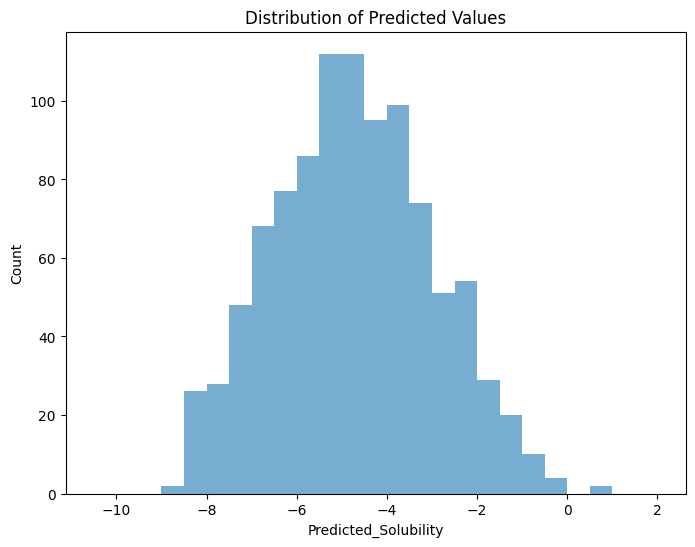

In [27]:
# Plots to observe the distribution of predicted values
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
bins=list(np.arange(-10.5,2.5,.5))

plt.hist(output['solubility'], bins=bins,alpha=0.6)
plt.ylabel('Count')
plt.xlabel('Predicted_Solubility')
plt.title('Distribution of Predicted Values')

figure_path = '/content/Ersilia-Model-Evaluation/figures/histogram.png'
plt.savefig(figure_path)


### Result Explanation
 From the output above, the prediction shows negative solubility values. Most of these values fall with the -2 to -6 range judging from the histogram above.


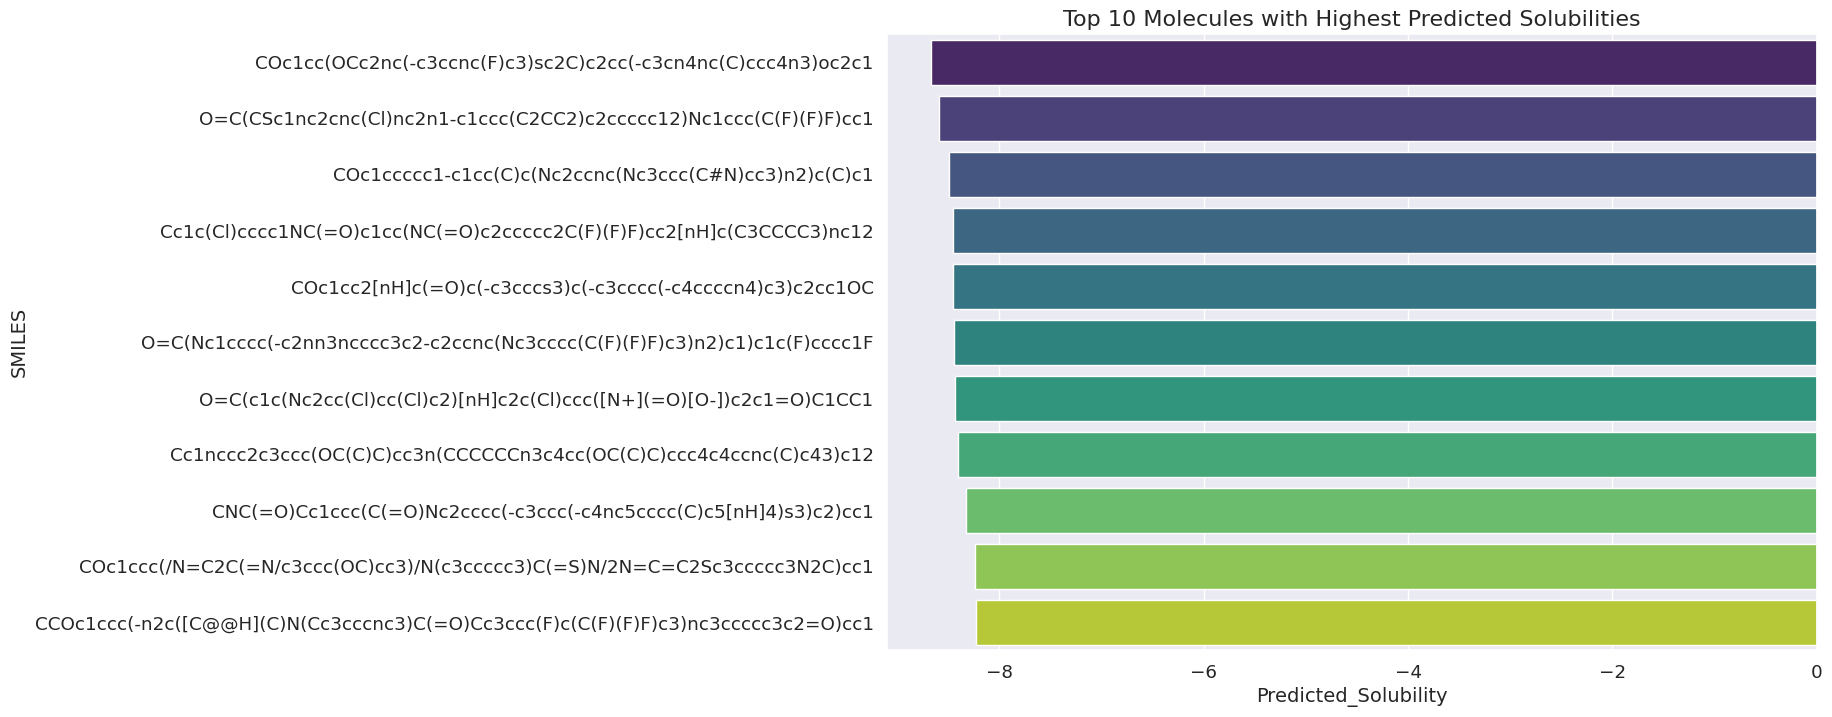

<Figure size 640x480 with 0 Axes>

In [28]:
import seaborn as sns

# Create a bar plot showing the top 10 molecules with highest predicted solubility
top_10_predictions = output.sort_values(by='solubility', ascending=True).head(11)
color_palette = sns.color_palette("viridis", len(top_10_predictions))
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.barplot(x='solubility', y='input', hue='input', data=top_10_predictions, palette=color_palette, dodge=False)
plt.xlabel('Predicted_Solubility', fontsize=14)
plt.ylabel('SMILES', fontsize=14)
plt.title('Top 10 Molecules with Highest Predicted Solubilities', fontsize=16)
plt.grid(True, axis='x')
plt.show()

figure_path = '/content/Ersilia-Model-Evaluation/figures/Barplot.png'
plt.savefig(figure_path)

In [29]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem
import numpy as np
from sklearn.decomposition import PCA


# Morgan Fingerprint funtion
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    finger_prints = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    array = np.zeros((1,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(finger_prints, array)
    return array

# Threshold set for hERG inhibitors
hERG_blockers_threshold = 0.5

output['Fingerprint'] = output['input'].apply(generate_fingerprint)

fingerprints = np.vstack(output['Fingerprint'])
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(fingerprints)

output.head()

,key,input,solubility,Fingerprint
0,SUTWUYBMBWPLMW-MDWZMJQESA-N,CCCCNC(=S)N/N=C/c1sccc1C,-3.454,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,RIYHJWOTNJXDLV-UHFFFAOYSA-N,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,-4.502,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,OGNBARHGQVMGGX-UHFFFAOYSA-N,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,-2.900,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,WQEXDIRUOYNDCM-UHFFFAOYSA-N,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,-4.777,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,YEGVLLQDOGYWDQ-OAHLLOKOSA-N,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,-4.473,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


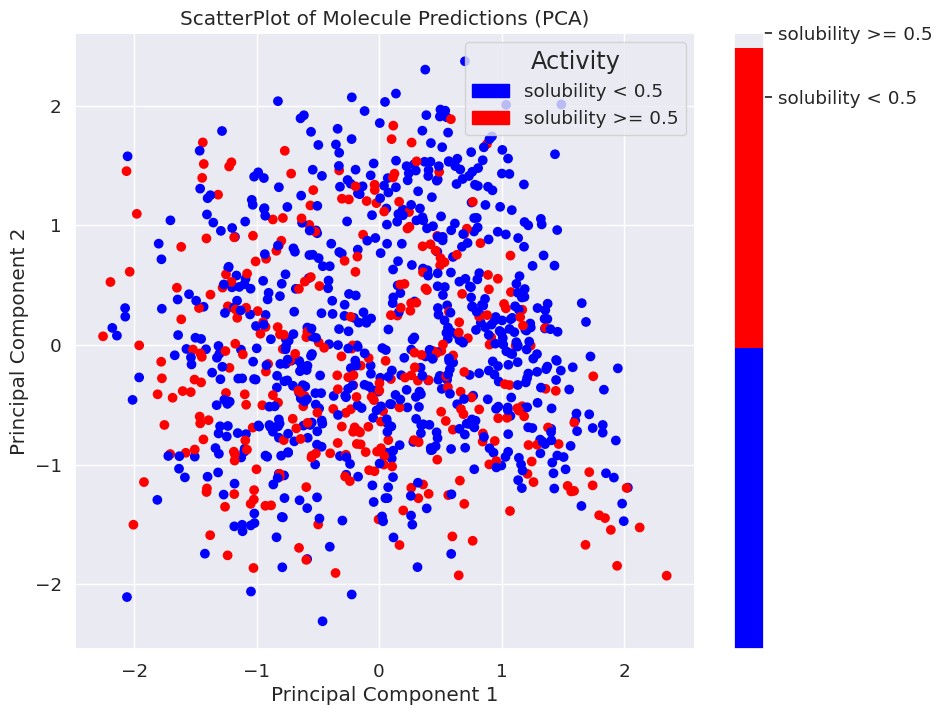

<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
legend_colors = ['blue', 'red']
# Plot scatterplot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=output['solubility'], cmap=mcolors.ListedColormap(legend_colors))
plt.title('ScatterPlot of Molecule Predictions (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

legend_labels = ['solubility < 0.5', 'solubility >= 0.5']

legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, loc='upper right', title='Activity', title_fontsize='large')

# Set colorbar ticks and labels
cbar = plt.colorbar(scatter)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(legend_labels)
plt.show()

figure_path = '/content/Ersilia-Model-Evaluation/figures/scatterplot.png'
plt.savefig(figure_path)

The scatterplot illustrates how molecules are distributed within a reduced two-dimensional space. Clusters of points suggest molecules with comparable fingerprints. Notably, these clusters correspond to molecules with similar solubility values.

The color distribution on the plot distinguishes between regions representing different prediction probabilities. Blue regions signify areas where the prediction probability is less than 0.5, indicating lower solubility, while red areas represent higher solubility, with prediction probabilities equal to or greater than 0.5. The plot reveals a notable prevalence of molecules exhibiting low solubility.

# Interpretation of Result

In the publication by eos6oli, a soluble compound is characterized as having a log S greater than -4, indicating its capability to form a 100 μM solution. The author also suggests the utility of SolTranNet in filtering out insoluble compounds.

Upon comparing the model's information with the generated predictions, it can be deduced that the model exhibits no bias based on the following outcome: effectively screening out 998 compounds with low solubility, characterized by a Log S of -10, and the inability to form a 100 μM solution.

Only 2 compounds possess Log S values greater than -4 and demonstrate the ability to form a 100 μM solution.

This observation implies that the model is unbiased.


# Checking Log S of solubility values

In [31]:
# Replace zero and negative values with a small positive value (e.g., 1e-10)
output['solubility'] = output['solubility'].apply(lambda x: x if x > 0 else 1e-10)

# Calculate the logS (base 10)
output['Log_S'] = np.log10(output['solubility'])

In [32]:
#unique values in Log S column
print(output['Log_S'].unique())

[-10.          -0.11013827  -0.28567023]


# Checking if compounds are being able to obtain a 100 μM solution


In [42]:

# Convert desired concentration (100 μM) to mol/L
desired_concentration_mol_per_L = 100e-6

# Check if solubility is greater than or equal to desired concentration
sufficient_solubility = output['solubility'] >= desired_concentration_mol_per_L

# Filter DataFrame to show compounds with sufficient solubility
compounds_sufficient_solubility = output[sufficient_solubility]

# Print compounds with sufficient solubility
print(compounds_sufficient_solubility)


                             key                    input  solubility
568  JCZPOYAMKJFOLA-IMJSIDKUSA-N       O[C@H]1CNC[C@@H]1O       0.776
830  SDUNKEQQLQDTTQ-YWEYNIOJSA-N  C[N+](C)(C)C/C=C1/COCO1       0.518


In [43]:

#Converting the result into a pandas dataframe
compounds_sufficient_solubility = pd.DataFrame(compounds_with_sufficient_solubility, columns=['key', 'input', 'solubility', 'Fingerprint'])
compounds_sufficient_solubility

,key,input,solubility,Fingerprint
568,JCZPOYAMKJFOLA-IMJSIDKUSA-N,O[C@H]1CNC[C@@H]1O,0.776,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
830,SDUNKEQQLQDTTQ-YWEYNIOJSA-N,C[N+](C)(C)C/C=C1/COCO1,0.518,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
